
# Analysis of data generated  from OSMR

https://github.com/osmr/imgclsmob





In [7]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [26]:
import numpy as np
import pandas as pd
import os, time
import datetime as dt
import itertools
import statsmodels.api as sm
from scipy.stats import kendalltau

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2020-12-31T12:06:43.294948-08:00

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



###  Helper Notebook to make Plots


In [28]:
import import_ipynb
import ModelPlots as MP

### To read the raw files generated

<pre>
pip install xlrd==1.2.0
</pre>

In [29]:
path = "./data/osmr"

In [30]:
df_all = pd.read_csv(path+"/df_all.csv")
df_all

Unnamed: 0          modelname     check  check_compound   checkTF  \
0             0  wrn28_10_cifar100  0.873725        0.773567  0.925764   
1             1      wrn28_10_svhn  0.601419        0.533661  0.449782   
2             2    wrn40_8_cifar10  0.532602        0.492409  0.326409   
3             3   wrn40_8_cifar100  0.791673        0.728488  0.952522   
4             4       wrn40_8_svhn  0.537902        0.495928  0.329377   
..          ...                ...       ...             ...       ...   
306         306        preresnet26  1.417044        0.871028  0.799257   
307         307     preresnetbc26b  1.923161        0.399779  0.514085   
308         308        preresnet34  1.210359        0.788568  0.847507   
309         309     preresnetbc38b  1.636872        0.357473  0.591398   
310         310        preresnet50  1.302540        0.298244  0.647826   

     checkTF_compound       norm  norm_compound   lognorm  lognorm_compound  \
0            0.812261  10.797475      10.652062  0.996938          0.988406   
1            0.394636   6.504677       6.296168  0.783711          0.766469   
2            0.298103   5.558056       5.492968  0.712637          0.708339   
3            0.869919   8.735812       8.755586  0.900006          0.899789   
4            0.300813   5.411185       5.329015  0.701243          0.694357   
..                ...        ...            ...       ...               ...   
306          0.820627   8.698458       8.658644  0.905574          0.890431   
307          0.267347   8.801484       8.730163  0.910042          0.890402   
308          0.860514   7.866827       7.894940  0.867597          0.860032   
309          0.286686   8.039993       7.766750  0.872862          0.848162   
310          0.296506   7.000760       6.925561  0.817860          0.804290   

     ...  sigma_mp  sigma_mp_compound  numofSpikes  numofSpikes_compound  \
0    ...  0.709364           0.667378     0.000000              0.000000   
1    ...  0.722710           0.692651     0.000000              0.000000   
2    ...  0.740547           0.719379     0.000000              0.000000   
3    ...  0.718941           0.689542     0.000000              0.000000   
4    ...  0.734079           0.713223     0.000000              0.000000   
..   ...       ...                ...          ...                   ...   
306  ...  0.921806           0.873345     2.231818              2.615079   
307  ...  0.863415           0.646415     5.827957             16.544061   
308  ...  0.922045           0.883865     1.500000              1.870370   
309  ...  0.856890           0.623130     4.978102             15.246612   
310  ...  0.842433           0.593998     4.966851             16.006289   

     ratio_numofSpikes  ratio_numofSpikes_compound  softrank_mp  \
0             0.000000                    0.000000   143.904470   
1             0.000000                    0.000000   336.553320   
2             0.000000                    0.000000   368.470762   
3             0.000000                    0.000000   173.518491   
4             0.000000                    0.000000   370.743275   
..                 ...                         ...          ...   
306           0.016345                    0.018776     0.968605   
307           0.029034                    0.073706     0.840359   
308           0.011611                    0.014262     1.261983   
309           0.023465                    0.067470     1.020744   
310           0.023362                    0.073795     1.397486   

     softrank_mp_compound  logpnorm  logpnorm_compound  
0              138.349114 -5.428285          -5.944612  
1              326.315932 -4.641690          -4.992451  
2              360.051882 -5.002736          -5.142759  
3              165.970009 -5.717918          -5.656400  
4              358.604449 -4.834103          -5.031324  
..                    ...       ...                ...  
306              0.926630  2.539925           2.38

### Remove outliers

- EfficientNet b0 and b1
- ResNext CIFAR00 all models

In [31]:
print("before removing outliers, we have {} models".format(len(df_all)) )
bad_models = ['efficientnet_b0', 'efficientnet_b1']
bad_models.extend(['resnext272_2x32d_cifar100', 'resnext29_16x64d_cifar100','resnext29_32x4d_cifar100','resnext272_1x64d_cifar100'])
for mname in bad_models:
    df_all = df_all[df_all.modelname!=mname]
print("after removing outliers, we have {} models".format(len(df_all)) )


before removing outliers, we have 311 models
after removing outliers, we have 305 models


### Plots with Test Accuracies

- read the test accuracies directly from the IOSMR site

In [32]:
from bs4 import BeautifulSoup
import requests
import re

In [33]:
'''Load the test accuracies'''
url = "https://github.com/osmr/imgclsmob/blob/master/pytorch/README.md"
df_accuracy = pd.read_html(url)

In [34]:
'''Create the matchtable: Match the model name'''
response = requests.get(url)
page = str(BeautifulSoup(response.content, features="lxml"))

## To find the category of models to group when plotting
models = re.findall('<li>(.*) \(<a href=', page) 

## The naming convention is not very consistent, therefore, to help with identification,
## I input the exceptions
exceptions = {'SqueezeNext': 'SqNxt', 'DIA-ResNet': 'DIA-PreResNet', 
              'DarkNet Ref/Tiny/19': 'DarkNet Tiny', 
              'IBN-ResNet/IBN-ResNeXt/IBN-DenseNet': 'IBN(b)-ResNet'} 
models_ = [m if m not in exceptions.keys() else m+'/'+exceptions[m] for m in models]
models_ = [m.split('/') for m in models_]

## Use reg exp to extract the dataset name, modelnames (used in README), and 
## modelnames (used in codes)
datasets = re.findall('<h3><a aria-hidden="true" class="anchor" href="#(.*)" id', page)
lst1_name = re.findall('<tr>\n<td>(.*)</td>', page)
lst2_name = re.findall('\n<td>.* \(<a href="(.*)">log</a>\)</td>\n</tr>', page)

if len(lst1_name) != len(lst2_name):
    print('Number does not match!')

df_table = pd.DataFrame(lst1_name, columns = ['Model'])

## Note: there are duplicate Model names, hence cannot use merge naively
df_table['modelname'] = [m.split('/')[-1][:-22] for m in lst2_name]

In [35]:
'''Identify the architexture for each pretrained model'''
class ContinueI(Exception):
    pass

continue_i = ContinueI()

arch = []
for i in range(len(df_table)):
    try:
        for mm in models_:
            for m1 in mm:
                ## Name convention 1: the model name starts with the arch name
                if df_table.loc[i, 'Model'].startswith(m1): 
                    arch.append(mm)
                    raise continue_i
        try:
            ## Name convention 2: if the model name starts with number, 
            ## the arch name is in the middle of the model name
            this = re.findall('[0-9]+-(.*)', df_table.loc[i, 'Model'])[0]
        except:
            arch.append(np.nan)
            raise continue_i

        for mm in models_:
            for m1 in mm:
                if this.startswith(m1):
                    arch.append(mm)

                    raise continue_i

        arch.append(np.nan)

    except ContinueI:
        continue

df_table['group'] = arch
df_table['group'] = df_table['group'].apply(lambda x: '/'.join(x))

In [36]:
'''Match the model name using matchtable'''
# df_all = pd.read_excel(path + '/df_all.xlsx').rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
df_all['spectralnormlog'] = np.log(df_all['spectralnorm'])

df_full = []
i = 0

for df in df_accuracy:
    # Because there are duplicate Model names (on README), you cannot
    # simply use merge
    df = df.copy()
    df['modelname'] = df_table.loc[i:i+len(df)-1, 'modelname'].tolist()#temp[i:i+len(df)]
    df['group'] = df_table.loc[i:i+len(df)-1, 'group'].tolist()
    i += len(df)

    del df['Remarks']

    df = df.merge(df_all, on = 'modelname', how = 'left')

    df_full.append(df)

df_full = dict(zip(datasets, df_full))

In [37]:
df_full['imagenet-1k']

Model   Top1   Top5     Params     FLOPs/2    modelname  \
0           AlexNet  38.50  16.64   62378344   1,132.33M      alexnet   
1         AlexNet-b  39.74  17.47   61100840     714.83M     alexnetb   
2             ZFNet  39.79  17.27   62357608   1,170.33M        zfnet   
3           ZFNet-b  36.37  14.90  107627624   2,479.13M       zfnetb   
4            VGG-11  29.90  10.36  132863336   7,615.87M        vgg11   
..              ...    ...    ...        ...         ...          ...   
301  ResNet(A)-101b  19.78   5.03   44568392   8,072.93M  resneta101b   
302  ResNet(A)-152b  19.62   4.82   60212040  11,796.83M  resneta152b   
303   ResNet(D)-50b  21.04   5.65   25680808  20,497.60M   resnetd50b   
304  ResNet(D)-101b  19.59   4.73   44672936  35,392.65M  resnetd101b   
305  ResNet(D)-152b  19.42   4.82   60316584  47,662.18M  resnetd152b   

          group  Unnamed: 0     check  check_compound  ...  sigma_mp_compound  \
0       AlexNet        50.0  6.312063        1.803071  ...           0.724677   
1       AlexNet        51.0  5.415376        1.641999  ...           0.743370   
2         ZFNet        52.0  4.725841        1.786327  ...           0.719677   
3         ZFNet        53.0  5.037417        1.844308  ...           0.650784   
4    VGG/BN-VGG        54.0  1.943881        1.474718  ...           0.757683   
..          ...         ...       ...             ...  ...                ...   
301      ResNet         NaN       NaN             NaN  ...                NaN   
302      ResNet         NaN       NaN             NaN  ...                NaN   
303      ResNet       247.0  0.734454        0.317371  ...           0.583746   
304      ResNet       248.0  0.518111        0.222608  ...           0.540957   
305      ResNet       249.0  0.435782        0.186991  ...           0.520966   

     numofSpikes  numofSpikes_compound  ratio_numofSpikes  \
0      39.181818             93.934603           0.221105   
1      32.581818             96.579048           0.224065   
2      40.036364             92.902857           0.225115   
3      63.672727            132.488889           0.265277   
4      31.818182             87.777778           0.132913   
..           ...                   ...                ...   
301          NaN                   NaN                NaN   
302          NaN                   NaN                NaN   
303     7.703518             24.818182           0.037639   
304     4.624352             15.430818           0.022697   
305     3.502618             11.917197           0.017155   

     ratio_numofSpikes_compound  softrank_mp  softrank_mp_compound  logpnorm  \
0                      0.142307     0.123766              0.121950  3.811582   
1                      0.145615     0.151018              0.130632  3.551809   
2                      0.144605     0.108592              0.113837  4.081376   
3                      0.182669     0.063393              0.074588  4.095295   
4                      0.131504     0.196762              0.169916  3.634474   
..                          ...          ...                   ...       ...   
301                         NaN          NaN                   NaN       NaN   
302                         NaN          NaN                   NaN       NaN   
303                    0.093492     1.185150              0.684582  1.803401   
304                    0.061941     1.952303              1.016048  0.886480   
305                    0.049233     2.374527              1.203890  0.490987   

     logpnorm_compound  spectralnormlog  
0             3.626827         4.701469  
1             3.467992         4.389939  
2             3.739922         4.345286  
3             3.805100         4.512583  
4             3.530661         3.256282  
..                 ...              ...  
301                NaN              NaN  
302                NaN              NaN  
303           1.385736         1.449708  
304           0.387835         0.874076  
305     

### Plots

In [38]:
'''[SETUP CELL] Start Plotting'''
metrics = ['alpha', 'alpha_weighted', 'spectralnormlog', 'softrank', 'norm', 'norm_compound' ] #specify the ww matrics
metrics_acc = ['Top1', 'Top5', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

metrics = ['alpha', 'alpha_weighted', 'spectralnormlog',  'softranklog',  'lognorm' ,'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy


### By Dataset, Metric (all models for each dataset)

Dataset imagenet-1k ['Top1']  11


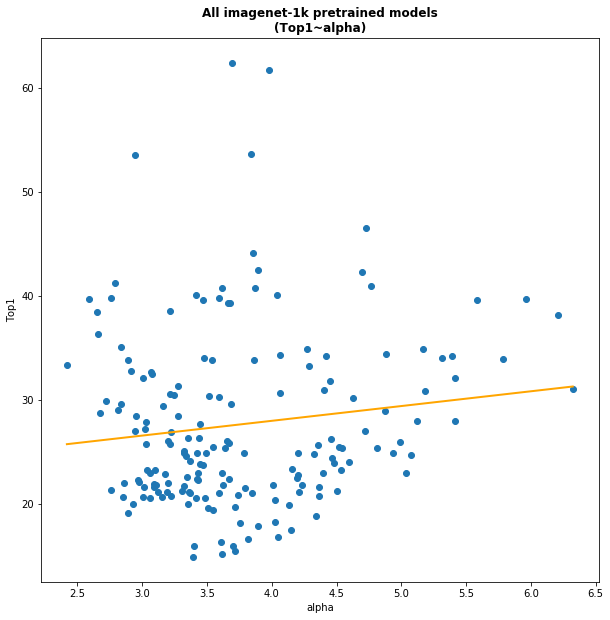

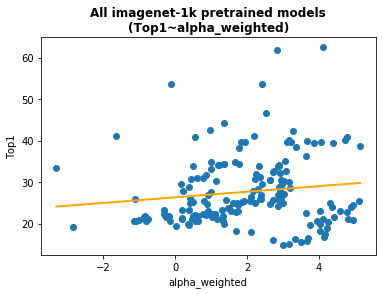

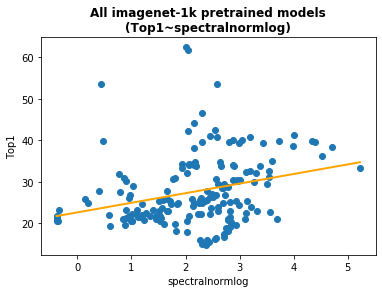

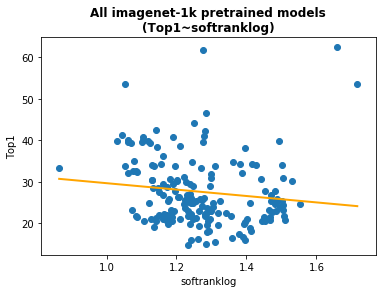

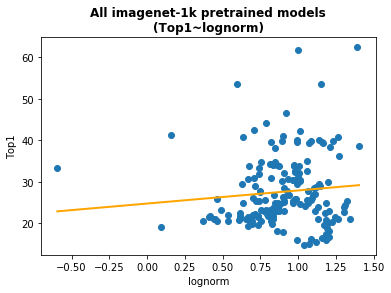

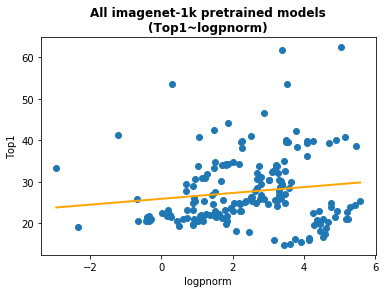

Dataset cifar-10 ['Error, %']  8


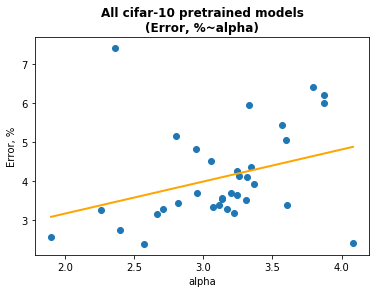

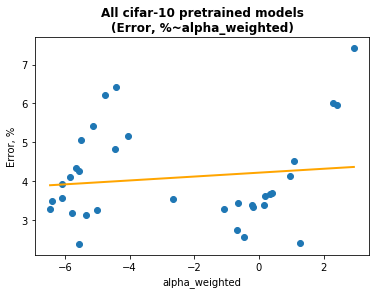

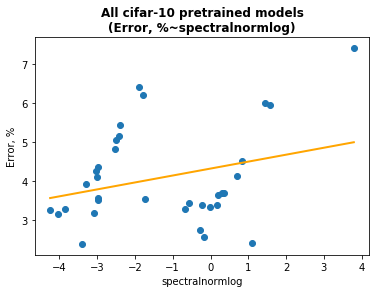

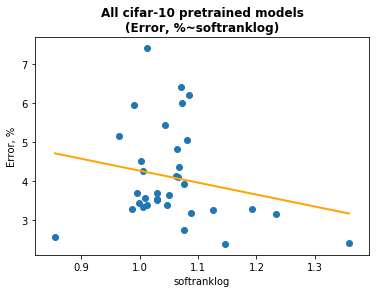

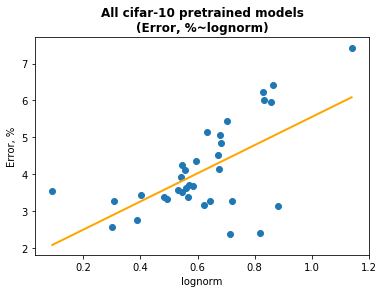

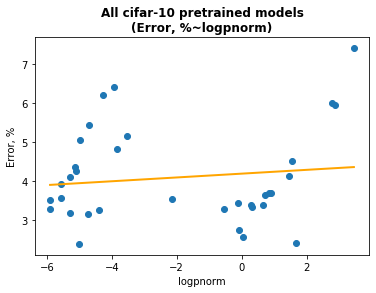

Dataset cifar-100 ['Error, %']  9


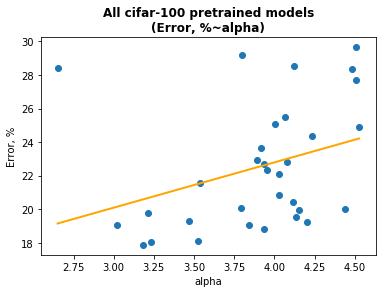

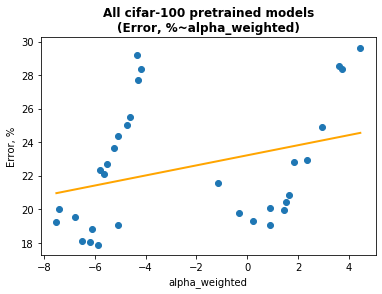

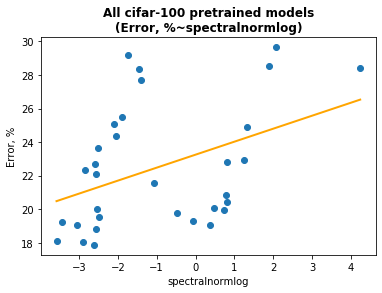

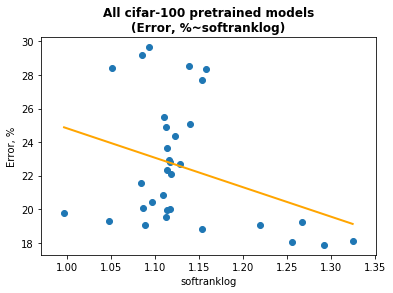

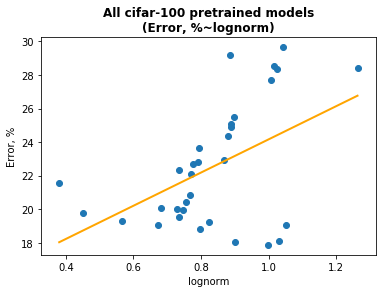

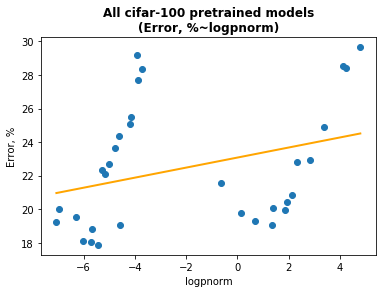

Dataset svhn ['Error, %']  4


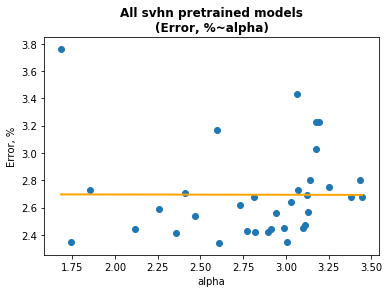

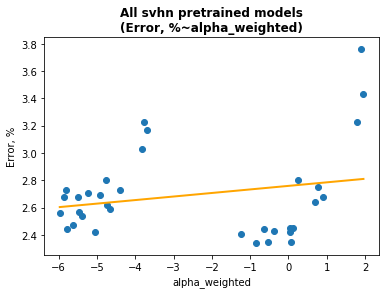

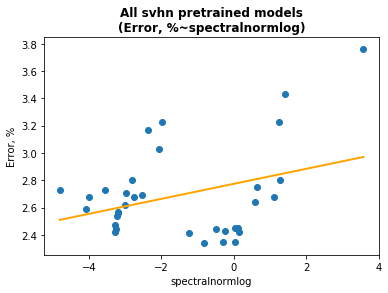

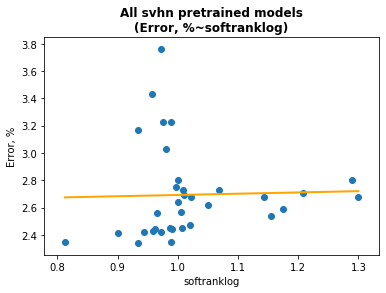

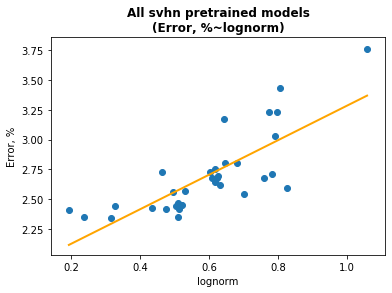

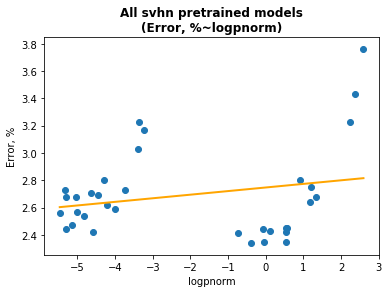

Dataset cub-200-2011 ['Error, %']  12


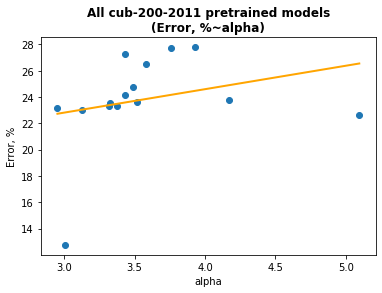

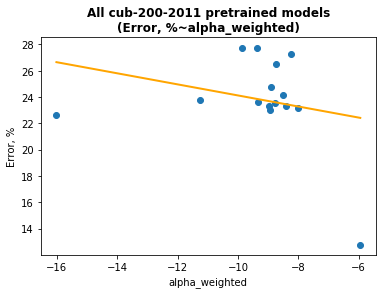

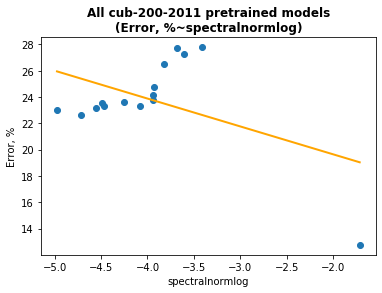

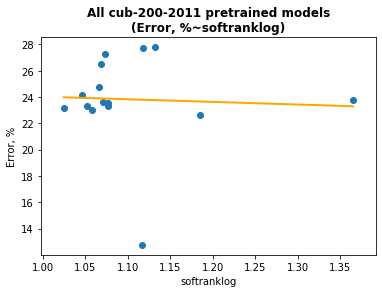

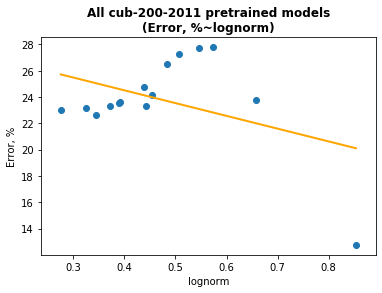

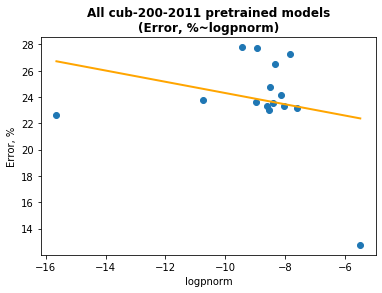

Dataset pascal-voc20102 ['Pix.Acc.,%', 'mIoU,%']  15


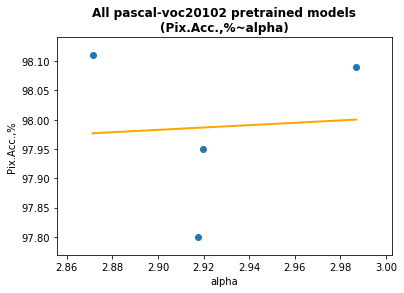

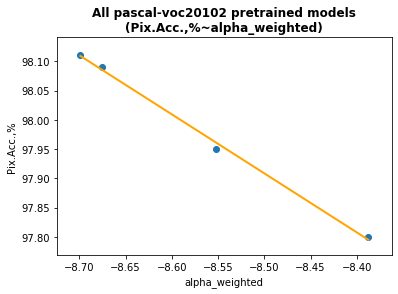

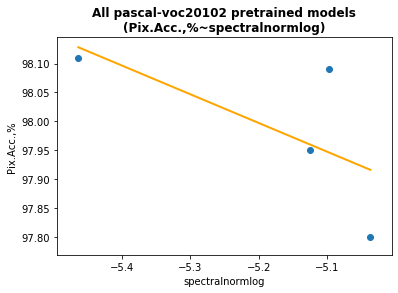

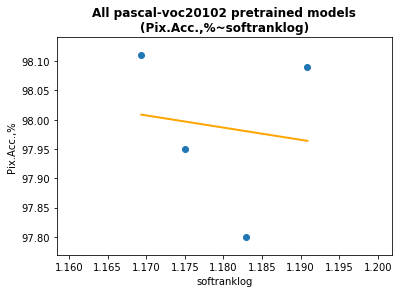

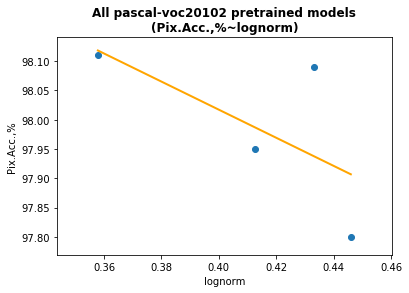

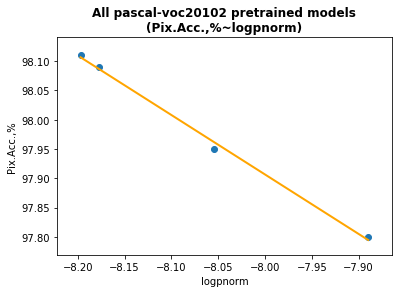

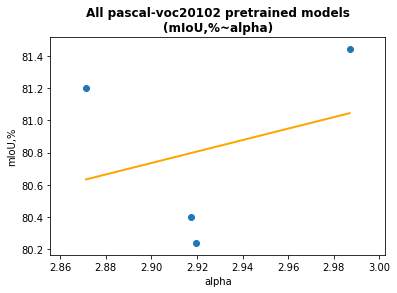

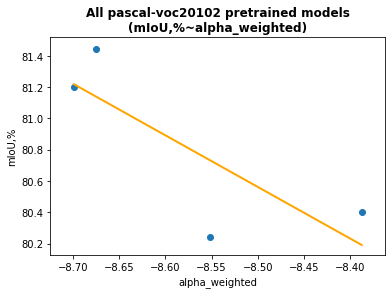

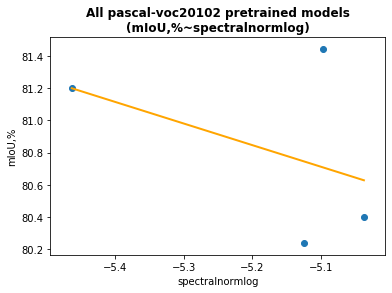

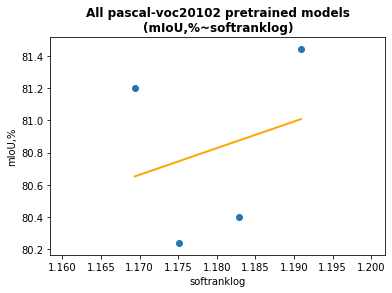

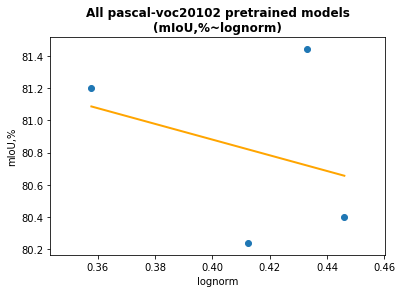

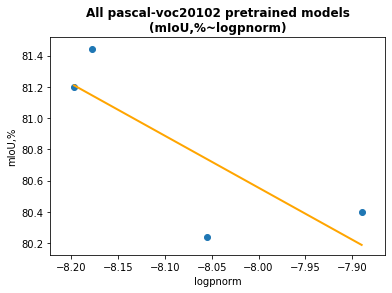

Dataset ade20k ['Pix.Acc.,%', 'mIoU,%']  6


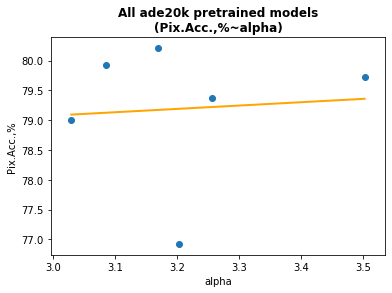

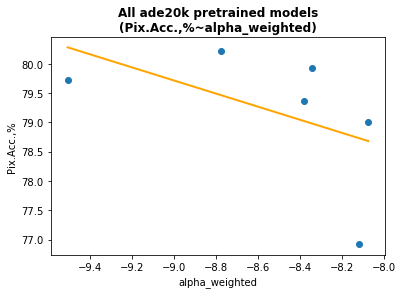

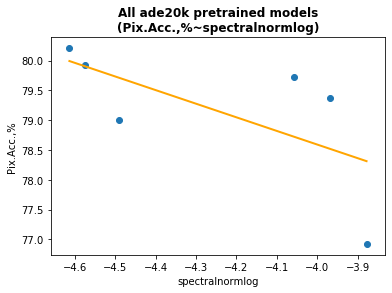

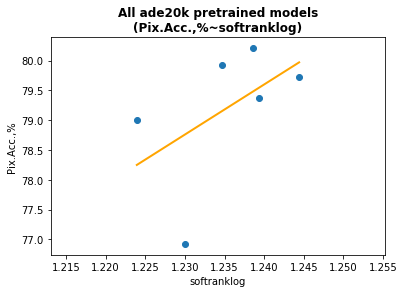

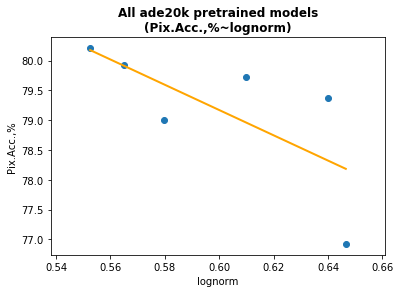

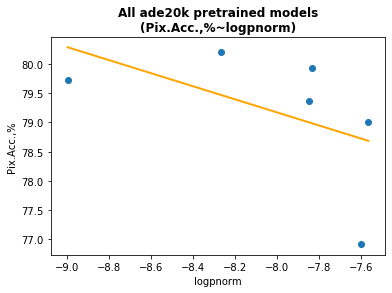

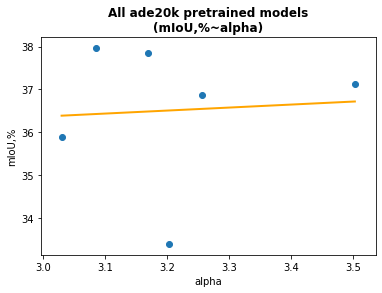

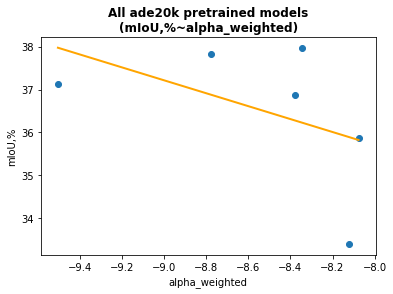

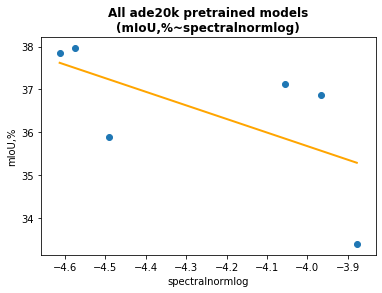

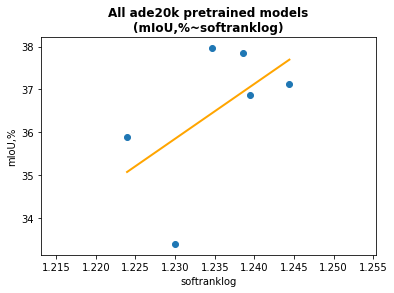

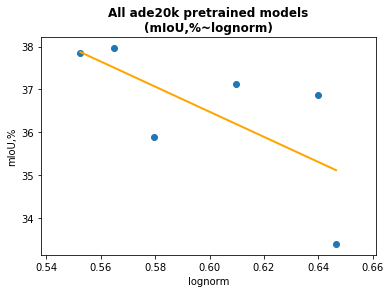

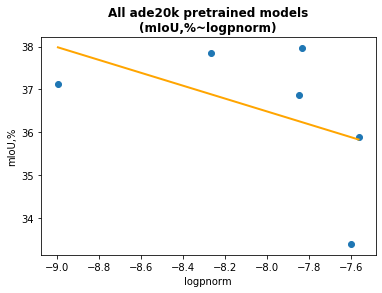

Dataset cityscapes ['Pix.Acc.,%', 'mIoU,%']  10


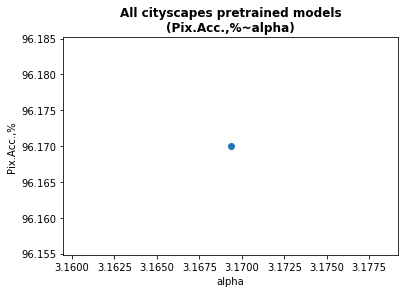

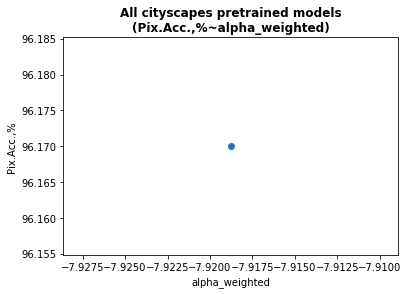

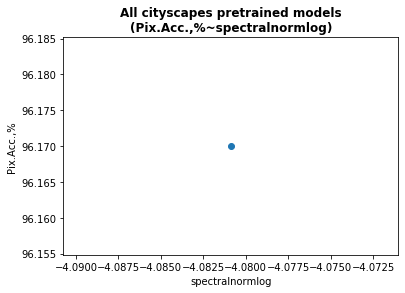

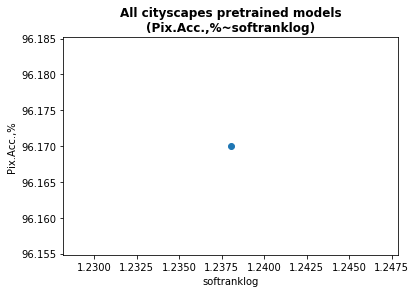

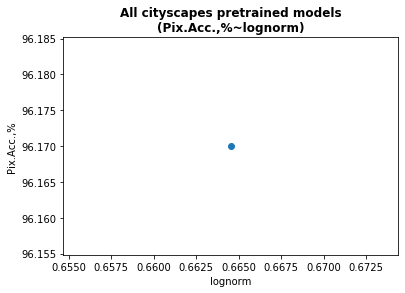

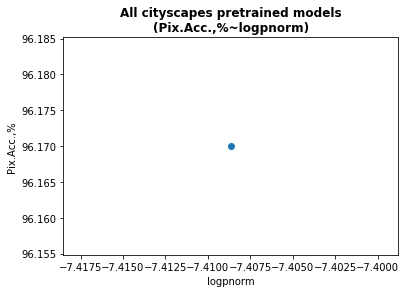

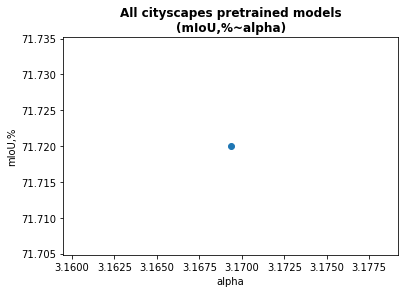

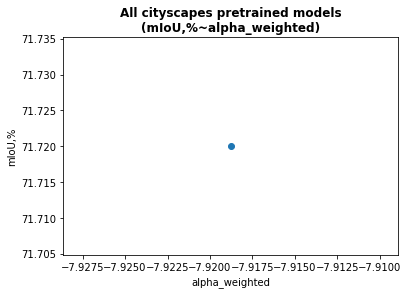

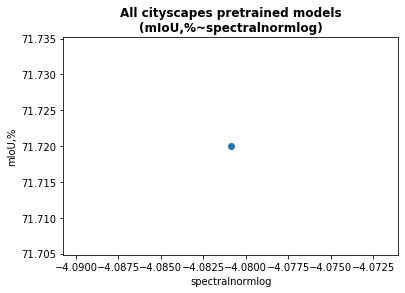

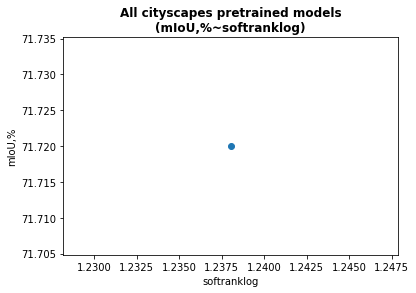

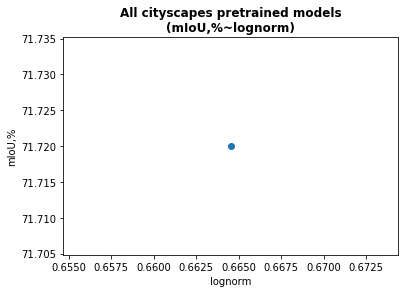

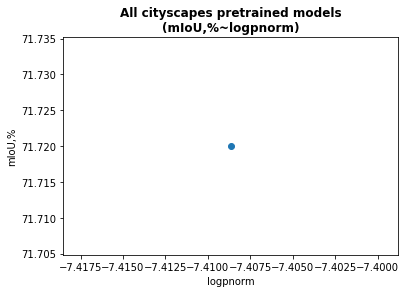

Dataset coco-semantic-segmentation ['Pix.Acc.,%', 'mIoU,%']  26


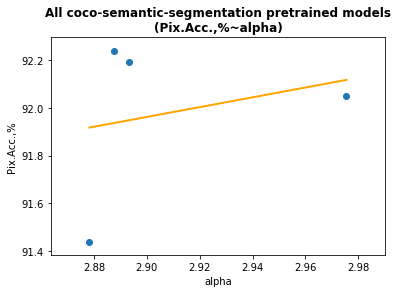

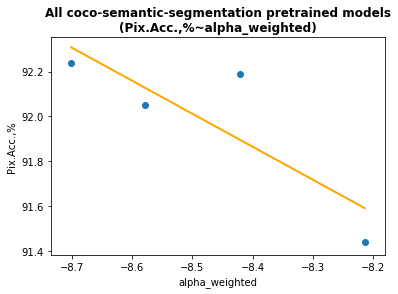

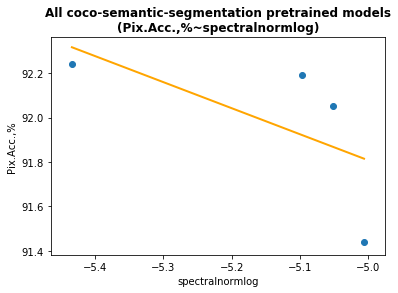

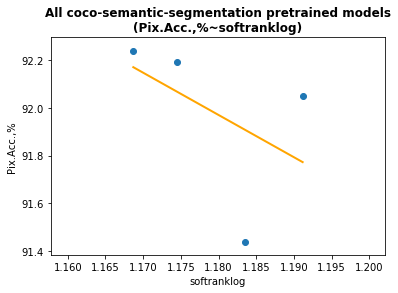

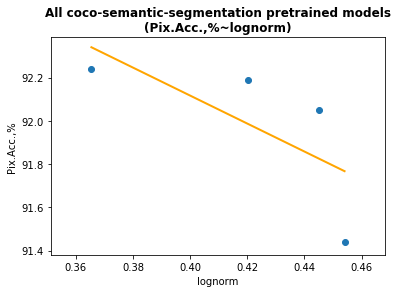

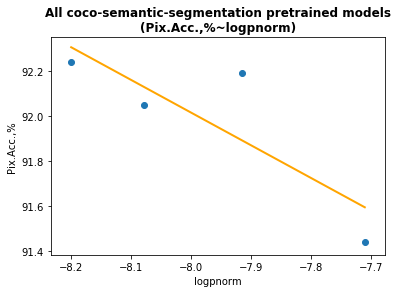

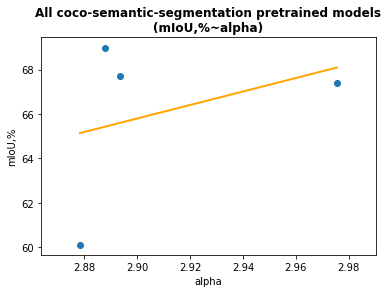

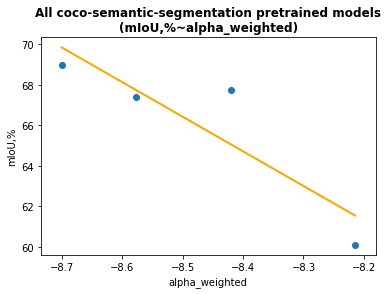

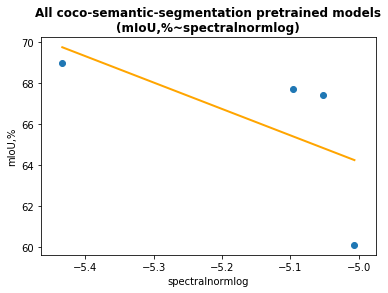

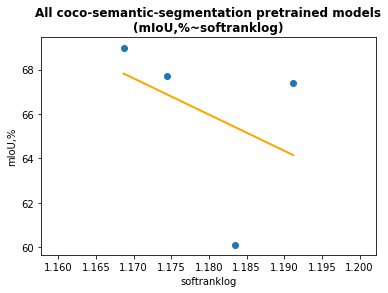

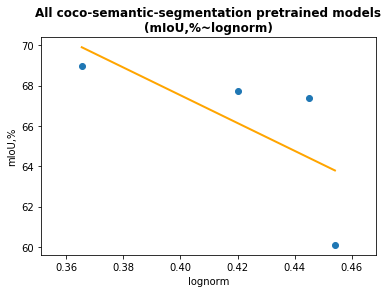

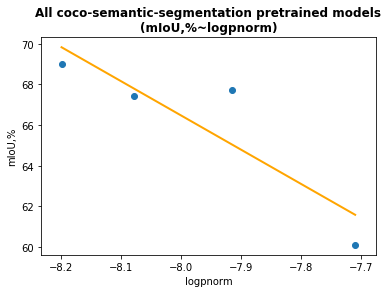

Dataset coco-keypoints-detection []  24


ValueError: 6 columns passed, passed data had 5 columns

In [39]:
plot_fit = True
plt.figure(figsize = (10,10))

    
'''Plotting by datasets'''
df_fit0 = []

for d in datasets:
    temp = df_full[d].copy()
    if len(temp) == 1:
        continue

    tacc = [c for c in metrics_acc if c in temp.columns]
    print("Dataset {} {}  {}".format(d,tacc, len(d)))
          
    try:
        for ac in tacc:
            for x in metrics:
                plt.scatter(temp[x], temp[ac])
                plt.xlabel(x)
                plt.ylabel(ac)
                plt.title('All {} pretrained models\n({}~{})'.format(d, ac, x), 
                        fontweight = 'bold')

                if plot_fit == True:
                    temp = temp.dropna().reset_index(drop = True)
                    this_fit = sm.OLS(temp[ac], sm.add_constant(temp[x].to_numpy())).fit()
                    this_x = np.linspace(min(temp[x]), max(temp[x]), 1000)
                    plt.plot(this_x, this_fit.predict(sm.add_constant(this_x)), linewidth = 2, color = 'orange')
                    df_fit0.append([d, ac, x, this_fit.ssr/len(temp), this_fit.rsquared])
                plt.show()
    except e:
        print(e)
        pass


del temp
del tacc

if df_fit0 != []:
    df_fit0 = pd.DataFrame(df_fit0, columns = ['dataset', 'test accuracy', 'x variable', 'MSE', 'r^2', ''])

##  Fit a linear regression for each Architecture Series, Dataset

- Compute  RMSE, R2, and Kendal-Tau statisitics


Dataset imagenet-1k Group ['Top1'] Mertric  11


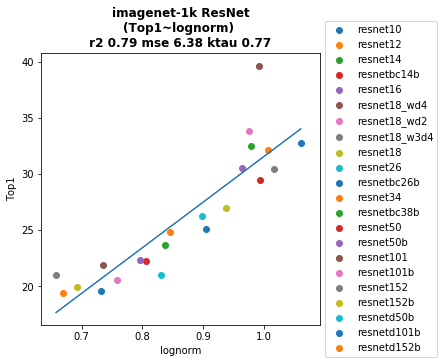

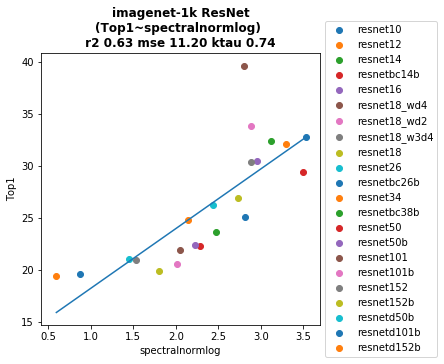

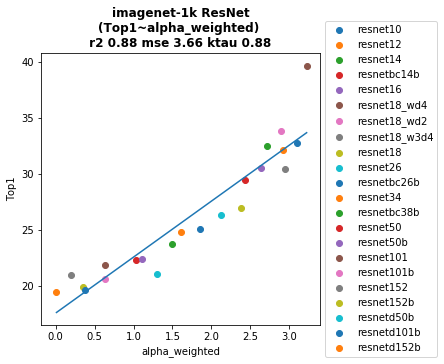

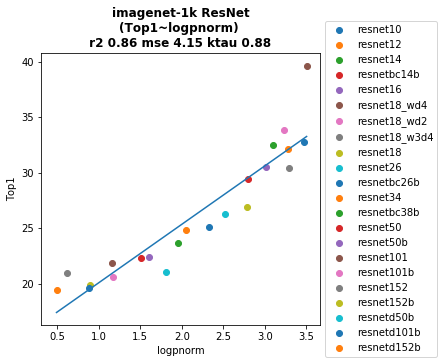

Dataset imagenet-1k Group ['Top1'] Mertric  11


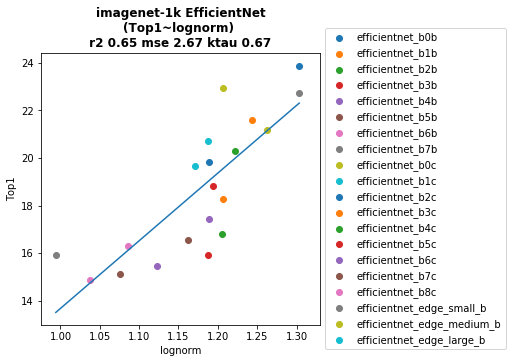

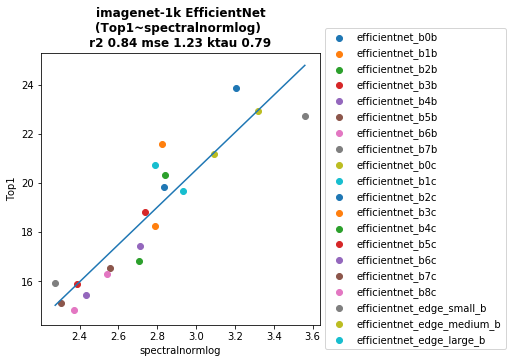

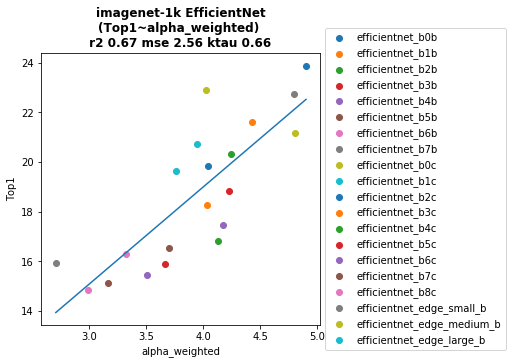

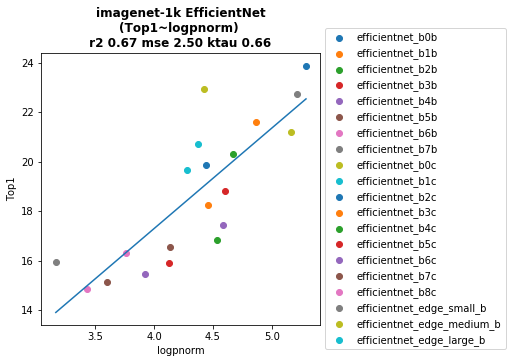

Dataset imagenet-1k Group ['Top1'] Mertric  11


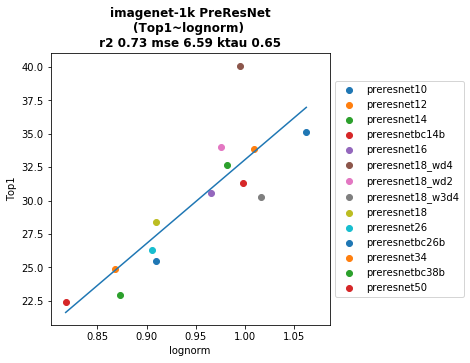

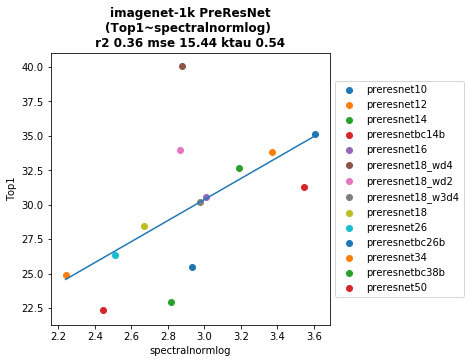

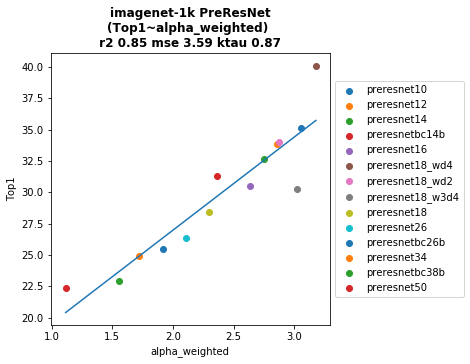

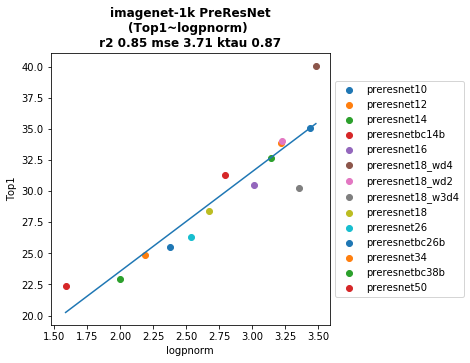

Dataset imagenet-1k Group ['Top1'] Mertric  11


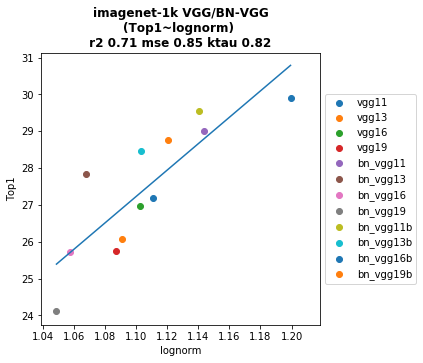

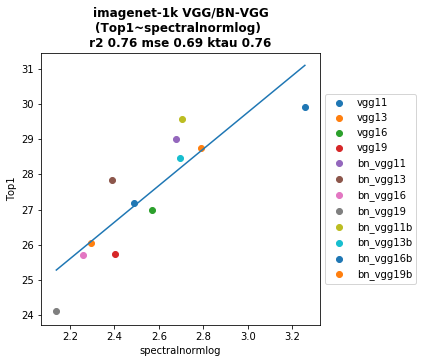

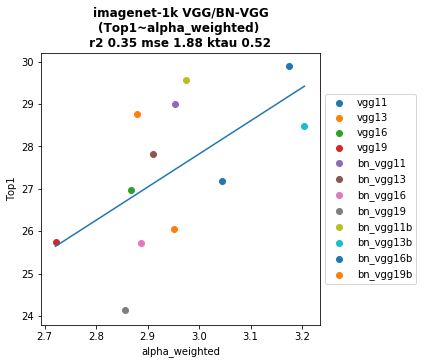

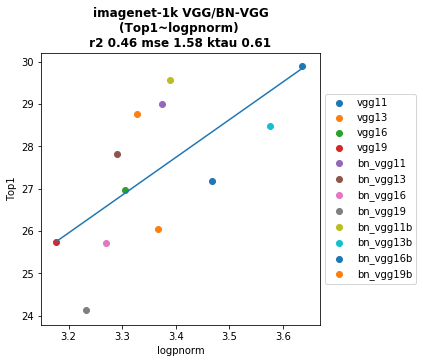

Dataset imagenet-1k Group ['Top1'] Mertric  11


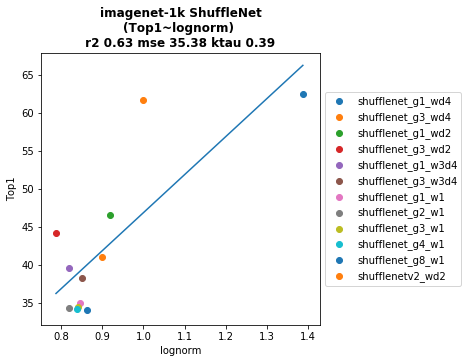

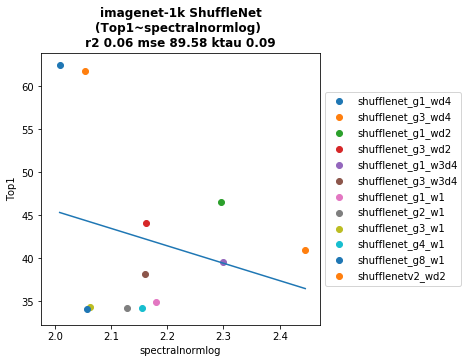

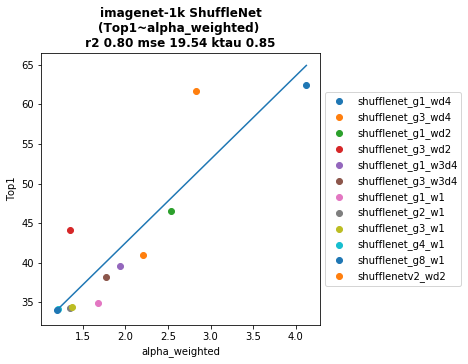

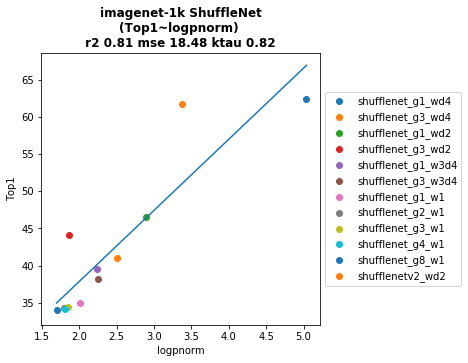

Dataset imagenet-1k Group ['Top1'] Mertric  11


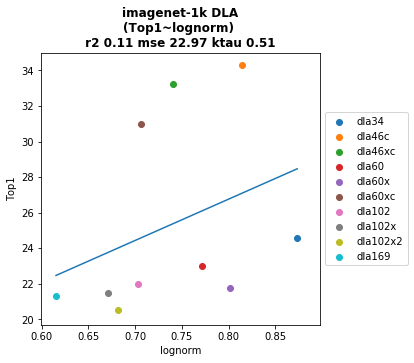

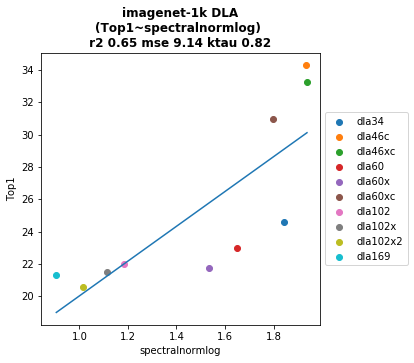

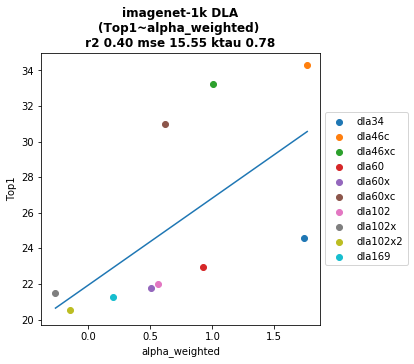

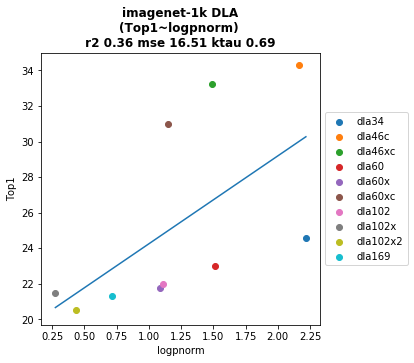

Dataset imagenet-1k Group ['Top1'] Mertric  11


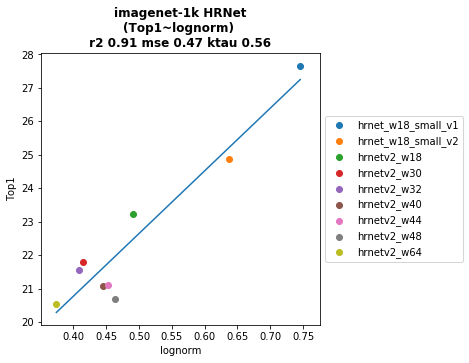

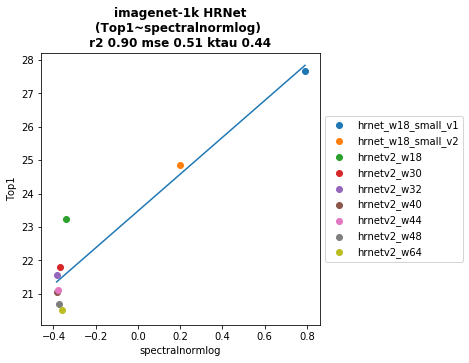

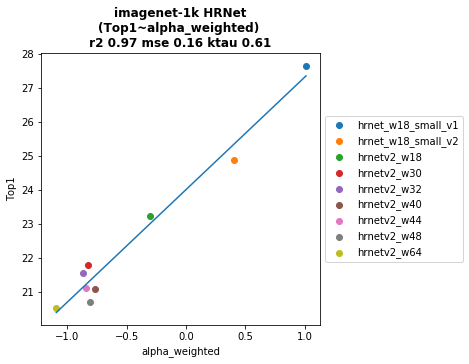

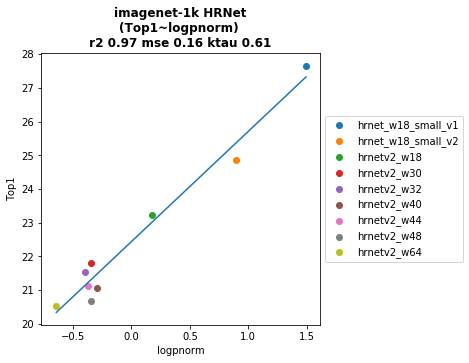

Dataset imagenet-1k Group ['Top1'] Mertric  11


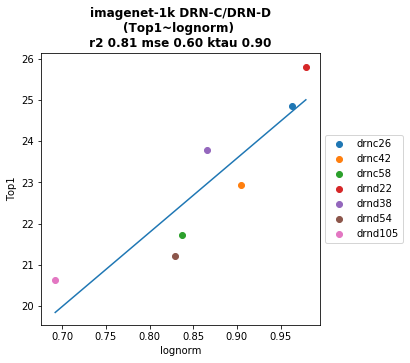

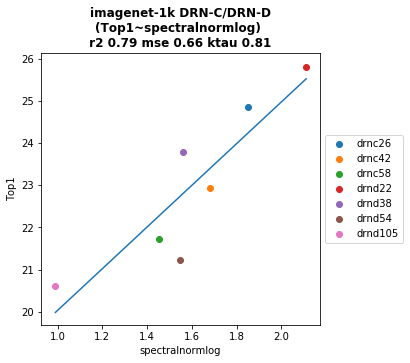

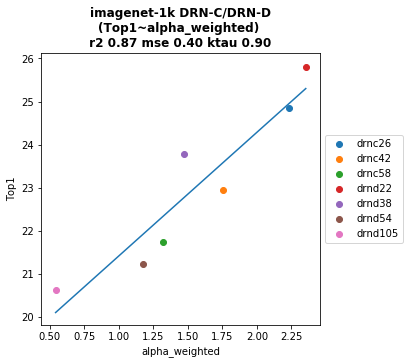

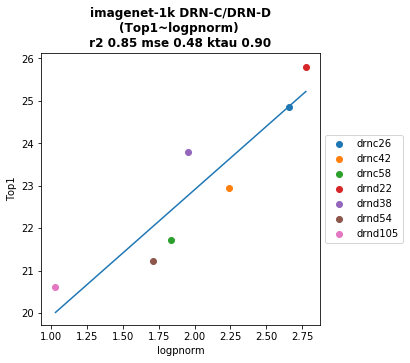

Dataset imagenet-1k Group ['Top1'] Mertric  11


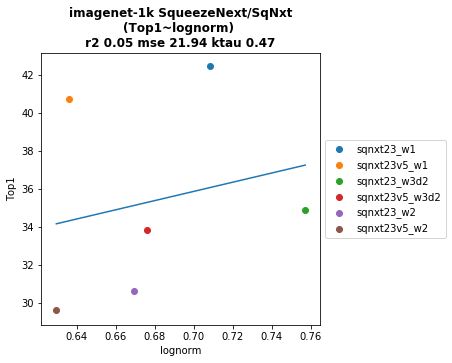

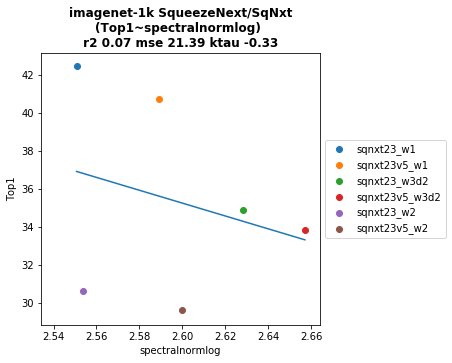

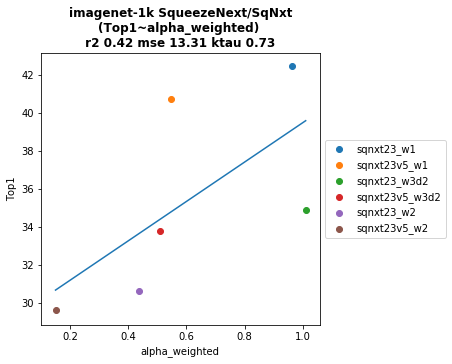

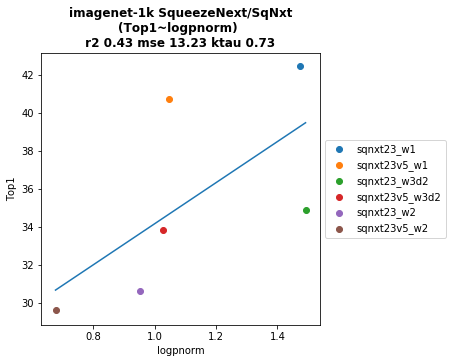

Dataset imagenet-1k Group ['Top1'] Mertric  11


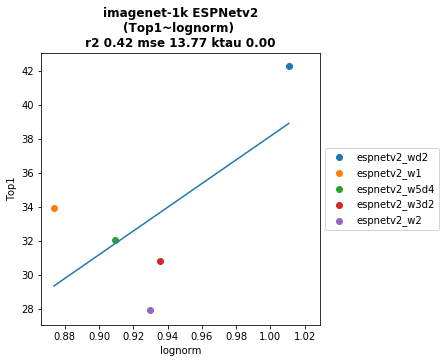

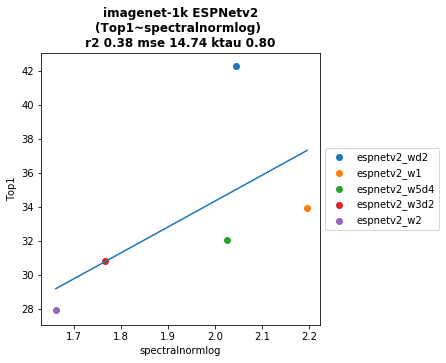

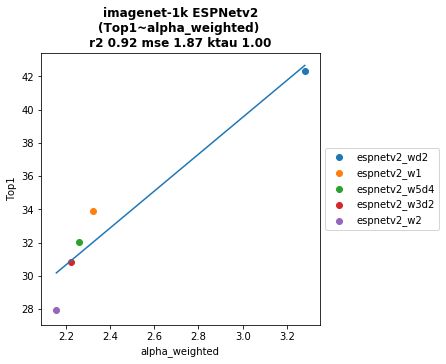

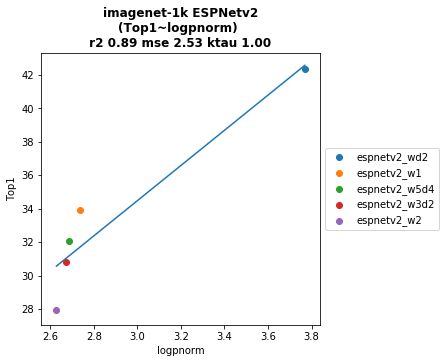

Dataset imagenet-1k Group ['Top1'] Mertric  11


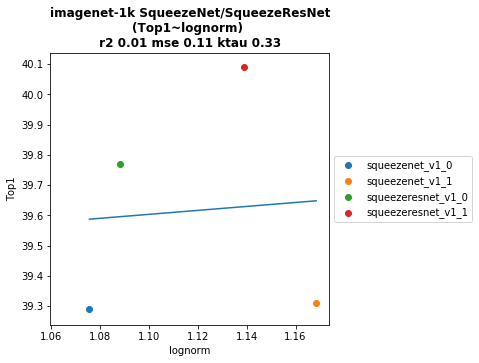

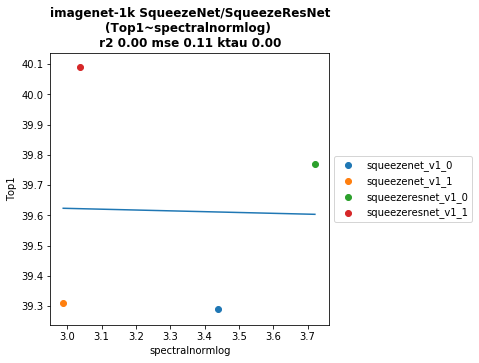

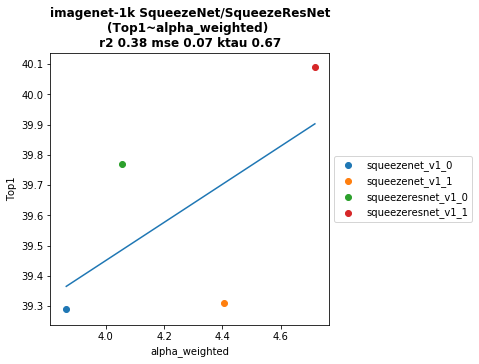

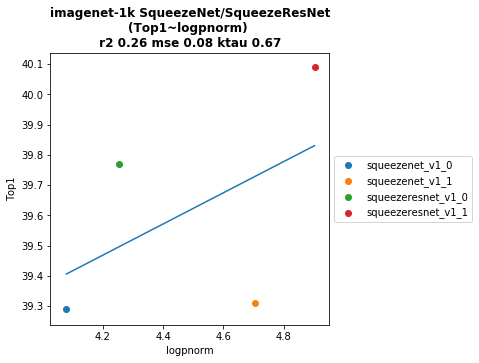

Dataset imagenet-1k Group ['Top1'] Mertric  11


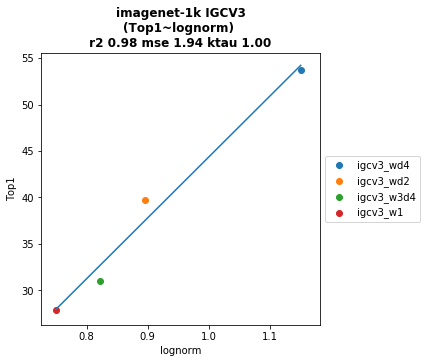

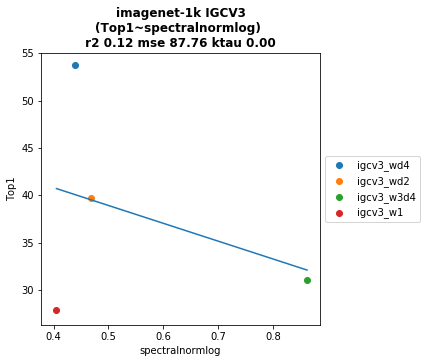

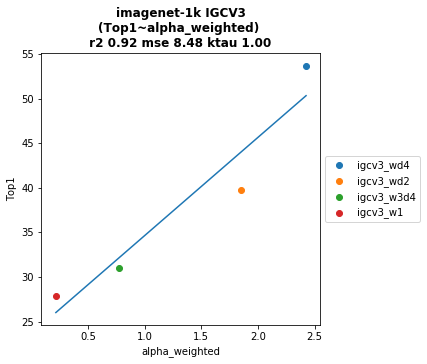

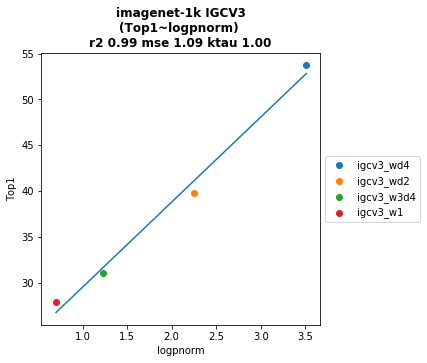

Dataset imagenet-1k Group ['Top1'] Mertric  11


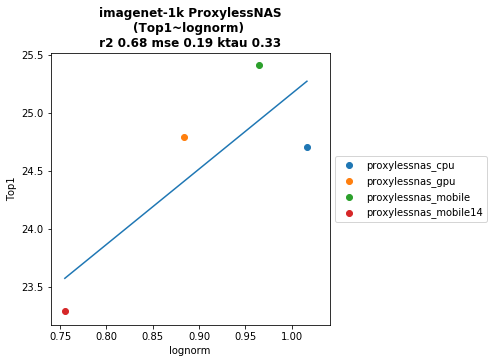

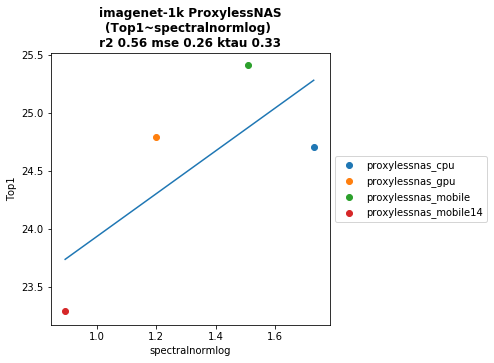

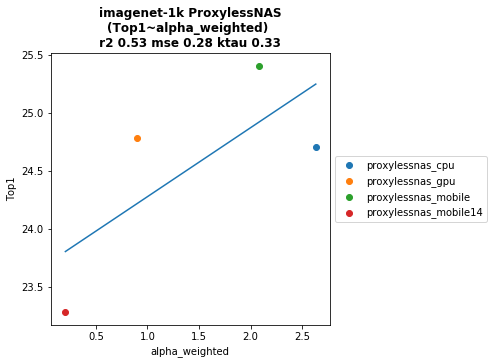

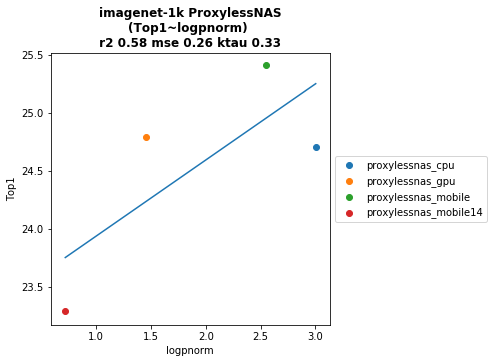

Dataset cifar-10 Group ['Error, %'] Mertric  8


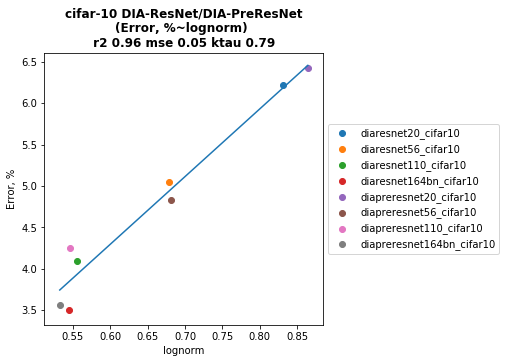

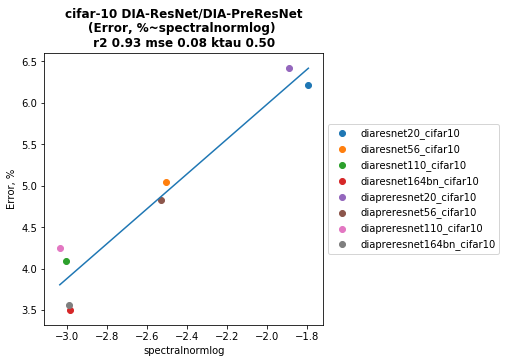

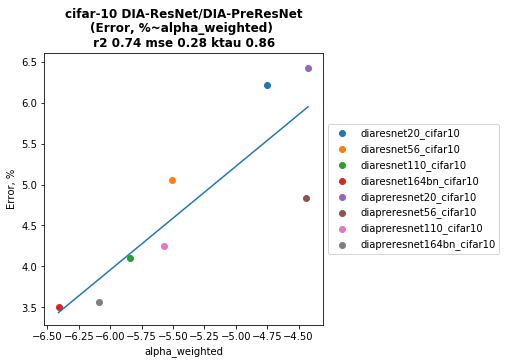

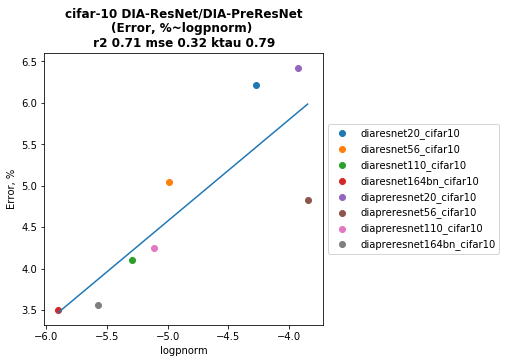

Dataset cifar-10 Group ['Error, %'] Mertric  8


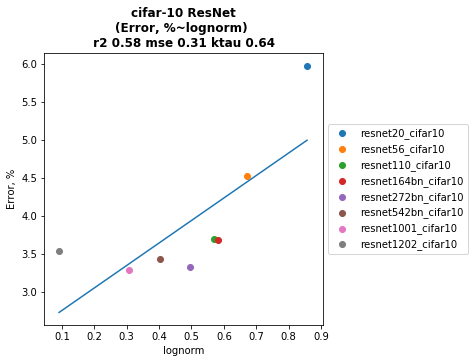

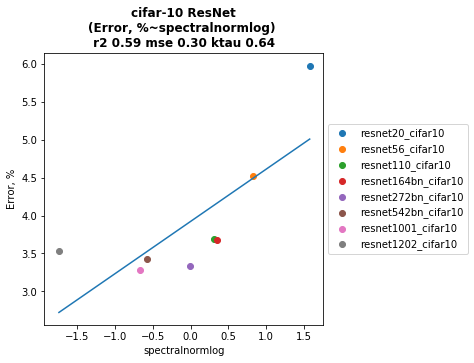

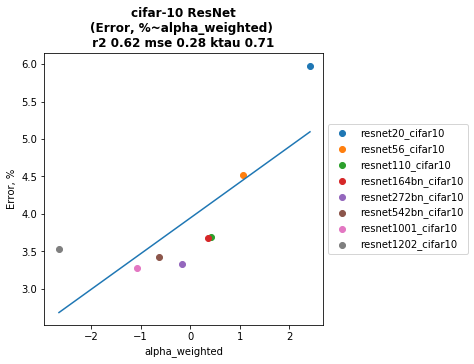

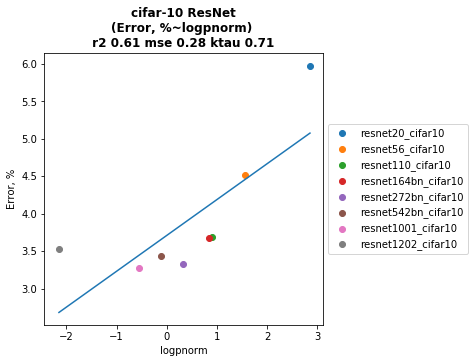

Dataset cifar-10 Group ['Error, %'] Mertric  8


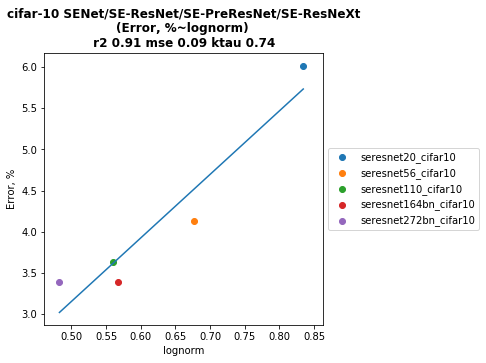

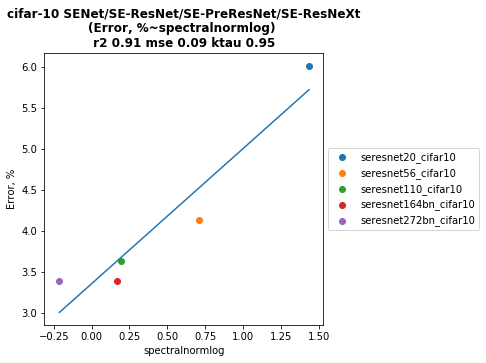

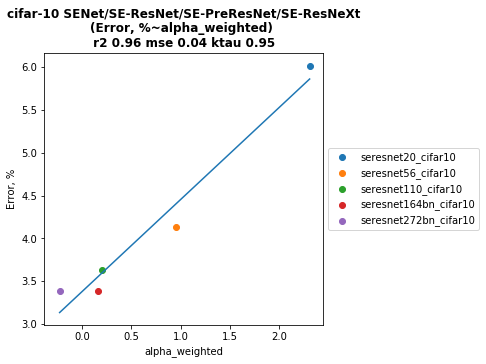

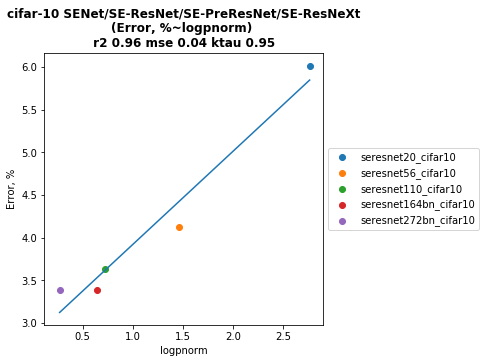

Dataset cifar-100 Group ['Error, %'] Mertric  9


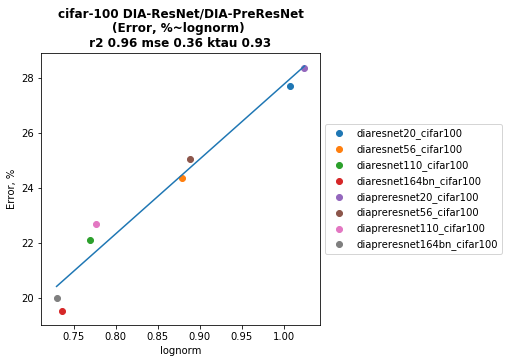

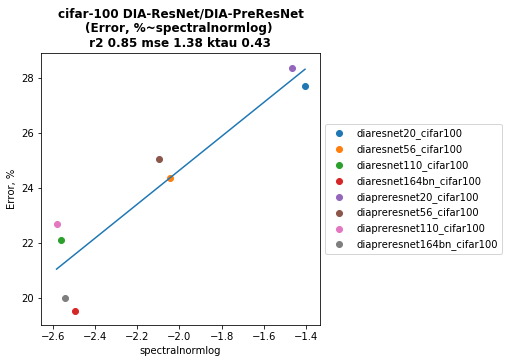

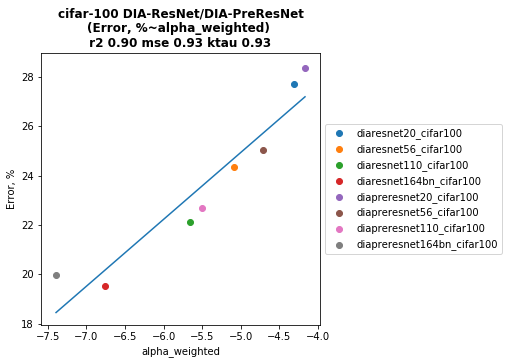

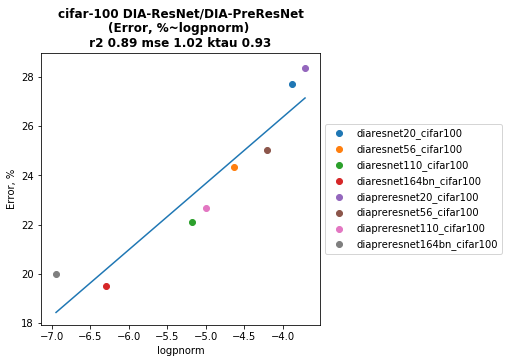

Dataset cifar-100 Group ['Error, %'] Mertric  9


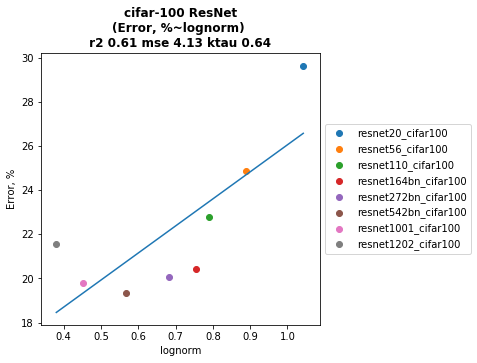

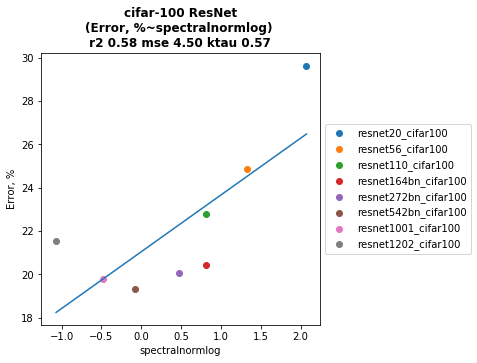

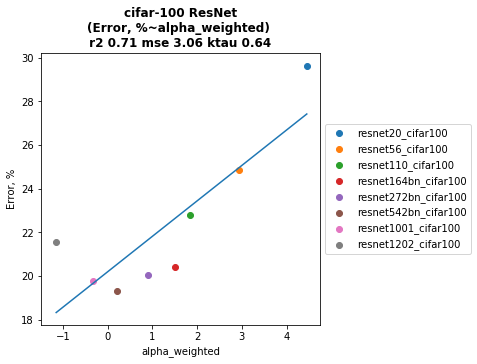

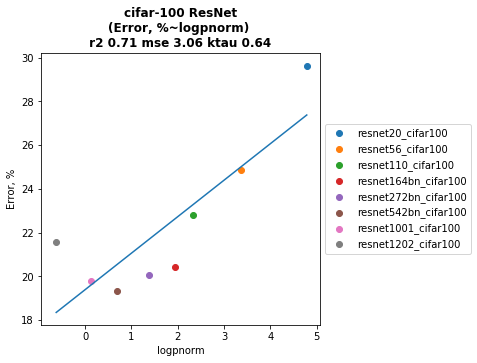

Dataset cifar-100 Group ['Error, %'] Mertric  9


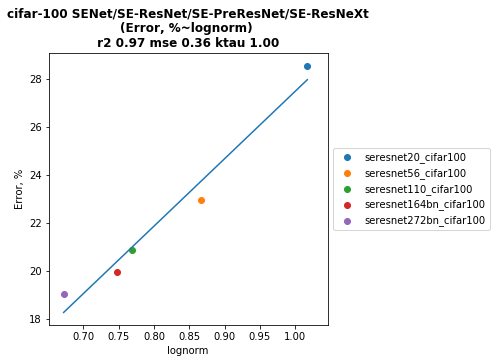

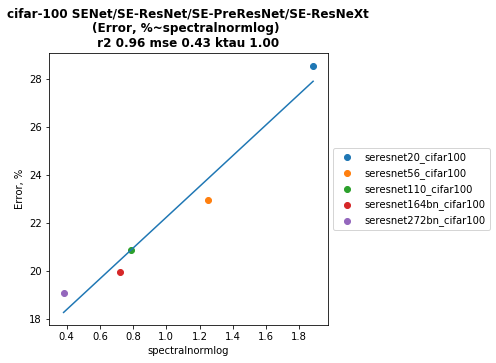

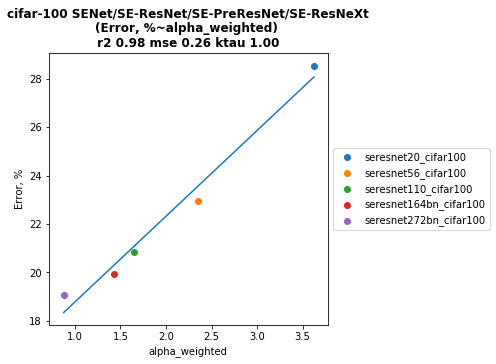

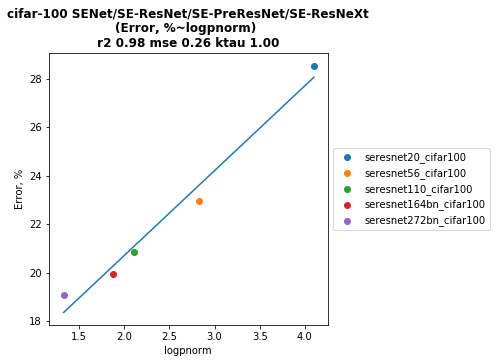

Dataset cifar-100 Group ['Error, %'] Mertric  9


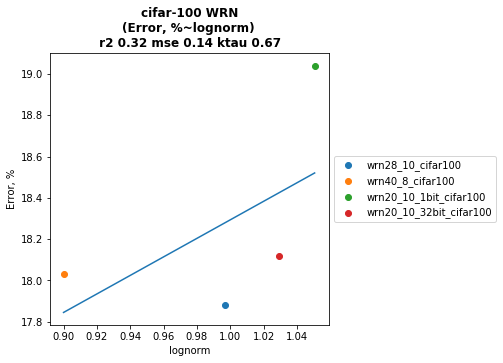

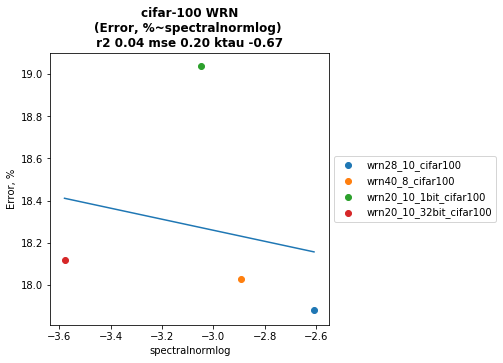

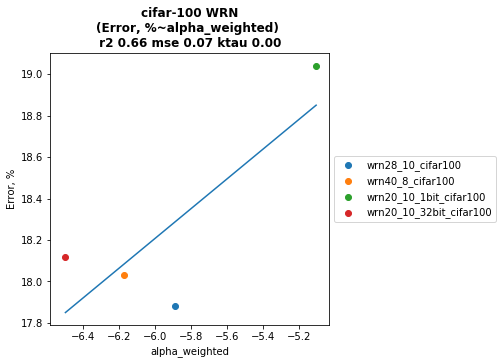

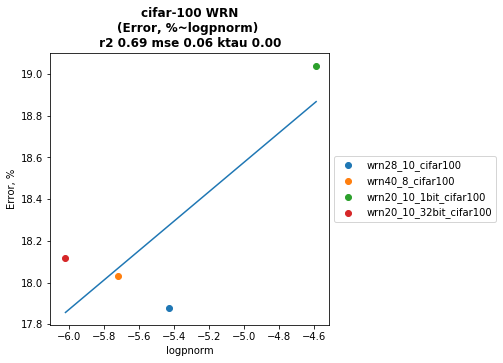

Dataset svhn Group ['Error, %'] Mertric  4


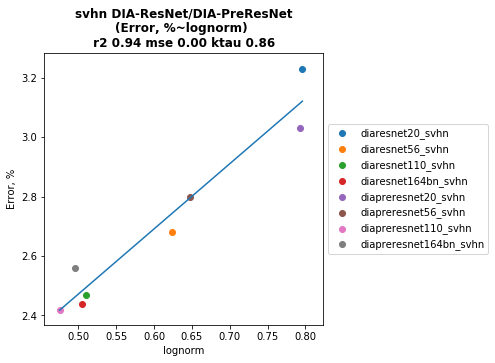

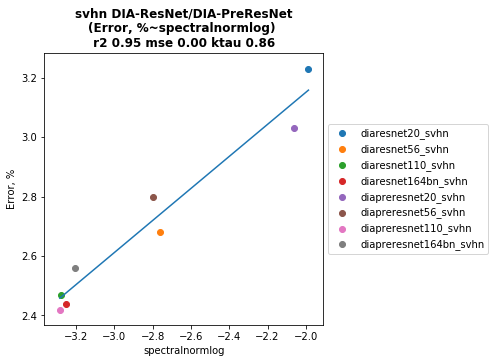

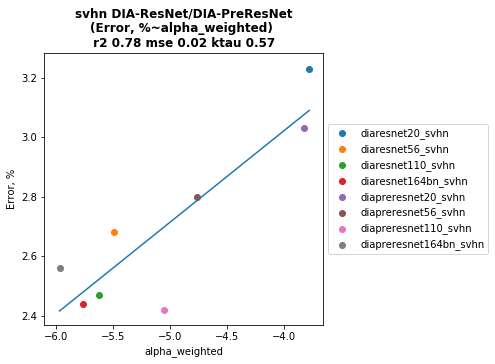

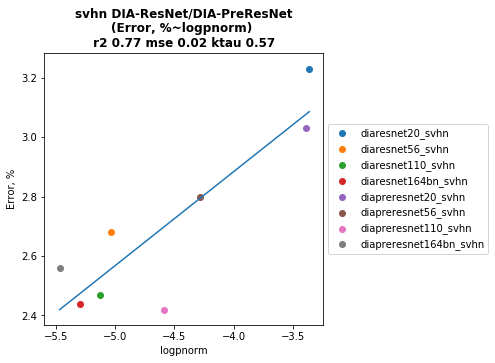

Dataset svhn Group ['Error, %'] Mertric  4


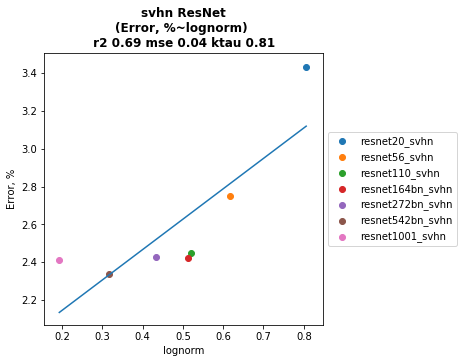

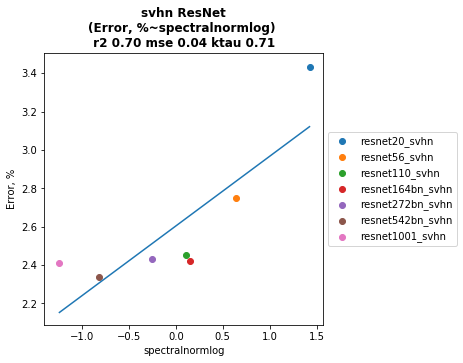

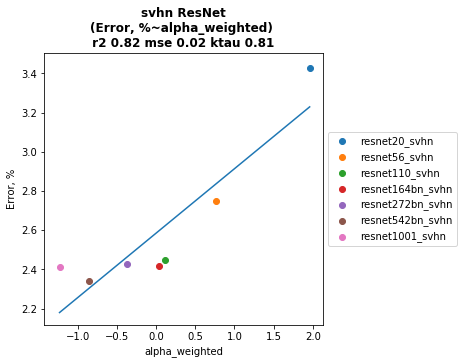

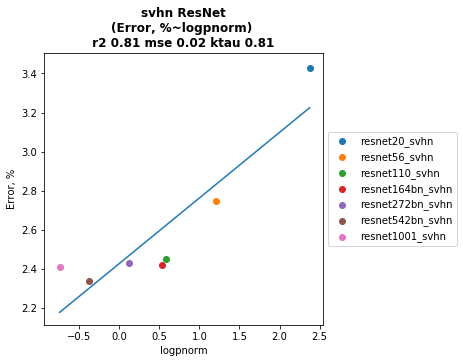

Dataset svhn Group ['Error, %'] Mertric  4


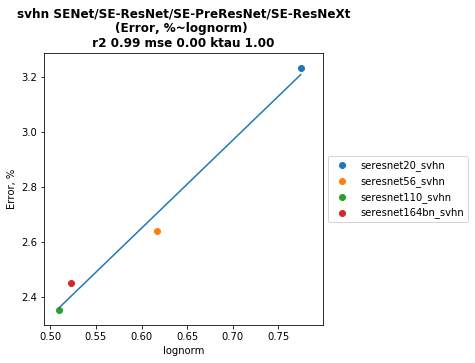

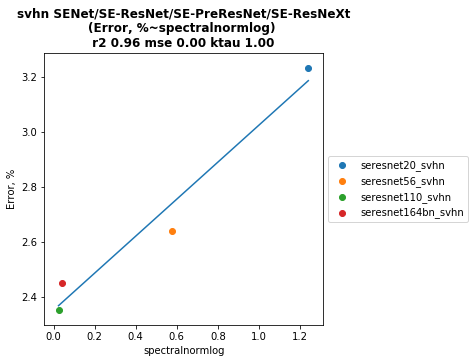

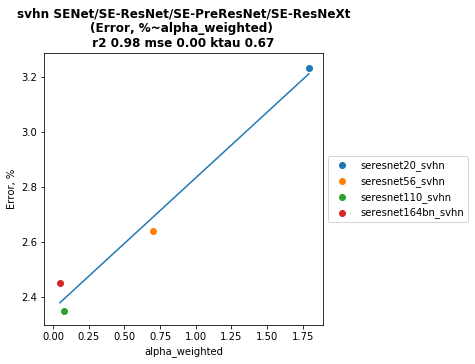

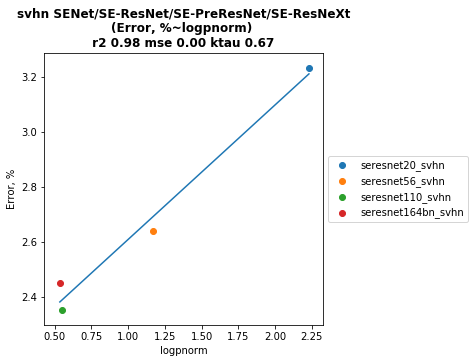

Dataset svhn Group ['Error, %'] Mertric  4


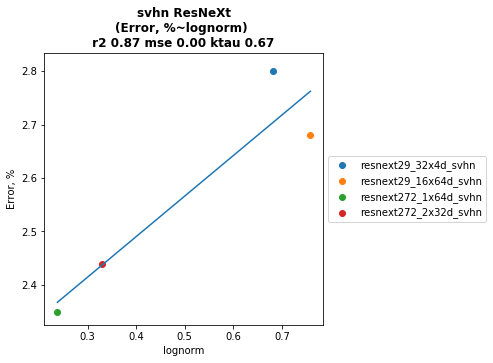

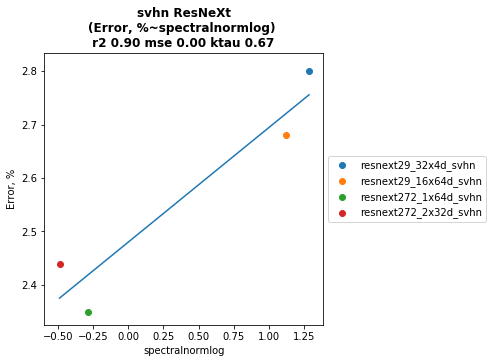

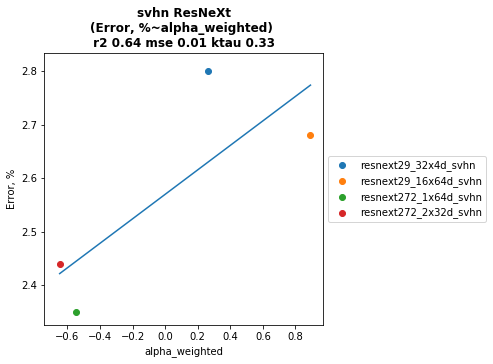

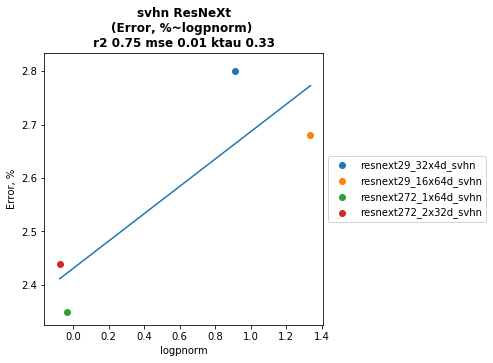

Dataset svhn Group ['Error, %'] Mertric  4


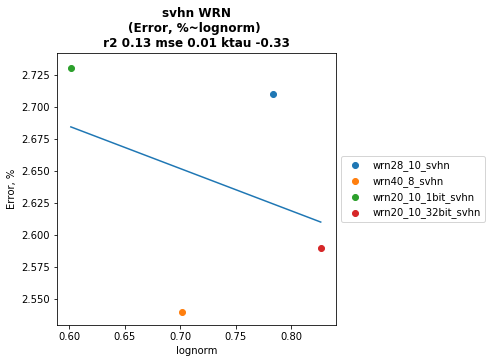

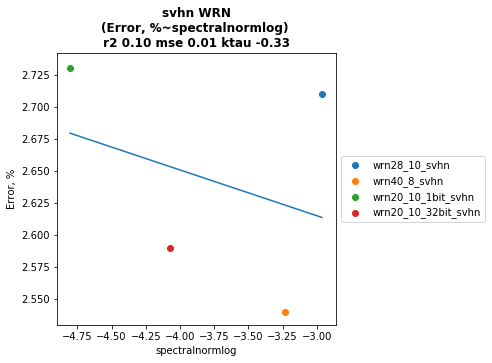

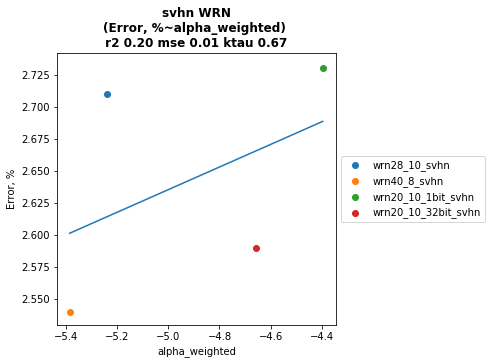

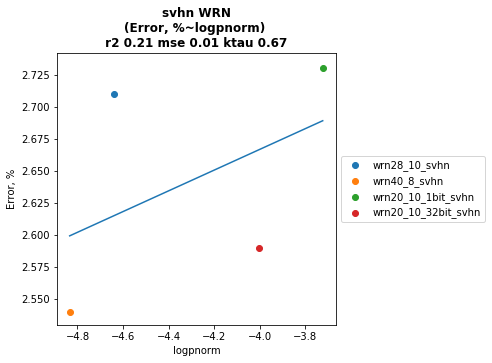

Dataset cub-200-2011 Group ['Error, %'] Mertric  12


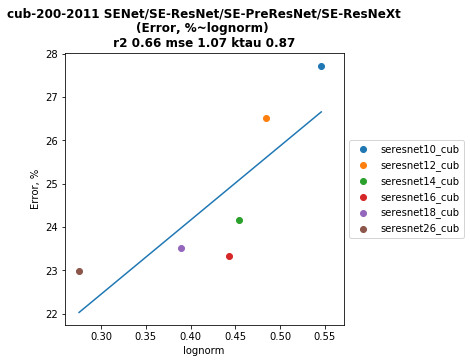

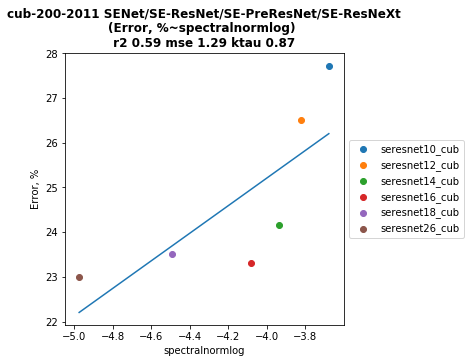

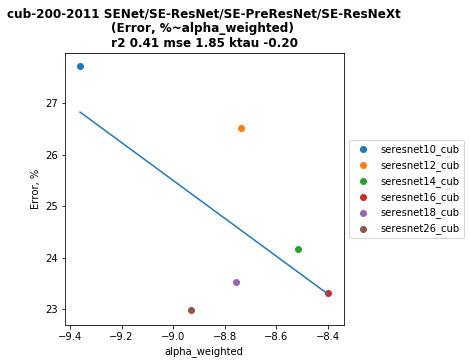

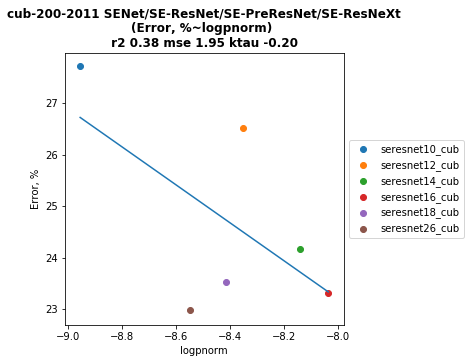

Dataset cub-200-2011 Group ['Error, %'] Mertric  12


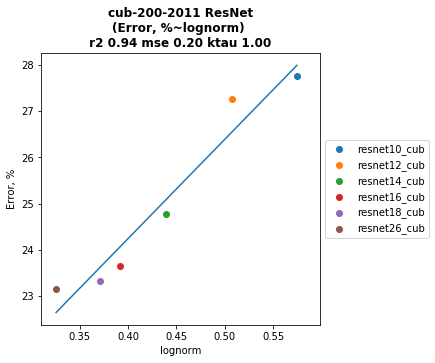

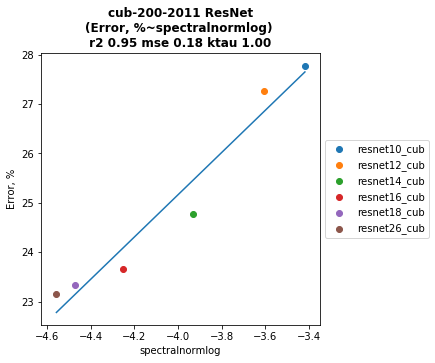

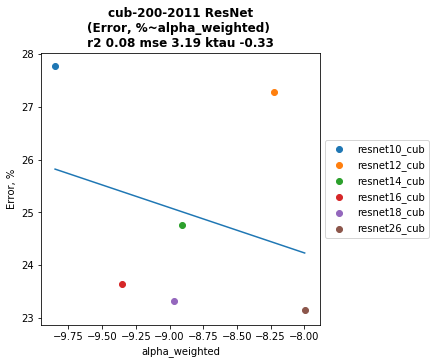

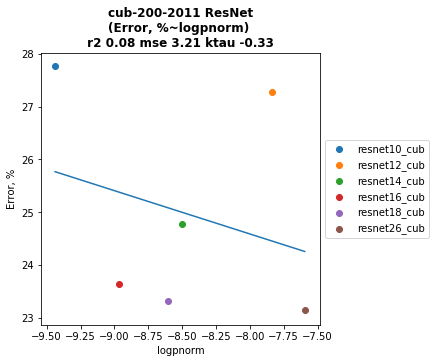

In [43]:
'''Fit a simple or polynomial on to the graph from above
ALL SIMPLE LINEAR FIT

output:
-------------------
1. Plots
2. df_fit (next cell): records the X, Y, degree, SSE and MSE for the fit'''
import warnings

metrics = [  'lognorm' ,'spectralnormlog',  'alpha_weighted' , 'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy


this_deg = 1

min_num_models = 4

df_fit = []
for d in datasets:
    df = df_full[d].copy()
    df.dropna(inplace=True)

    this_groups = df['group'].value_counts().to_frame()

    
    for g in this_groups[this_groups['group'] >= min_num_models].index:

        this_group = df[df['group'] == g].copy()
        this_group = this_group.dropna().reset_index(drop = True)
        n = len(this_group) #size

        tacc = [c for c in metrics_acc if c in this_group.columns]

        for ac in tacc:
            print("Dataset {} Group {} Mertric  {}".format(d,tacc, len(d)))

            for x in metrics:
                plt.figure(figsize = (5,5))

                try:
                    for i in range(len(this_group)):
                        plt.scatter(this_group.loc[i,x], this_group.loc[i, ac], label = this_group.loc[i, 'modelname'])
                    plt.xlabel(x)
                    plt.ylabel(ac)
                    title = '{} {}\n({}~{})'.format(d, g,ac, x)
                 

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")  

                        this_fit = sm.OLS(this_group[ac], sm.add_constant( this_group[x] )).fit()
                        coef = this_fit.params[x] 
                        this_x = np.linspace(min(this_group[x]), max(this_group[x]), 50)

                        plt.plot(this_x, this_fit.predict(sm.add_constant(this_x))) ##coef[0]*this_x**2 + coef[1]*this_x + coef[2]) 
                        this_sse = this_fit.ssr 
                        this_rsquared = this_fit.rsquared

                        ktau, pvsl = kendalltau(this_group[x] ,this_group[ac])

                        this_arch = [d, g, ac, x, this_deg, n, this_rsquared, this_sse, this_sse/n, ktau]
                        title += " \n r2 {:03.2f} mse {:03.2f} ktau {:03.2f} ".format(this_rsquared, this_sse/n, ktau)


                        plt.title(title, fontweight = 'bold')
                        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #this_group['Model']
                        plt.show()

                                         

                except np.linalg.LinAlgError: #does not converge
                    print("{} did not converge {}".format(d))
                    this_arch = [d, g, ac, x, this_deg, n, 'Not converge', np.nan, np.nan, np.nan]

                    
                except:
                    pass
                         
                df_fit.append(this_arch)
                
                
                